<a href="https://colab.research.google.com/github/shahad-jeza/kaust_training/blob/main/Basic_CNN_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.display import clear_output

In [ ]:
# Download the required libraries (needed when running outside colab where the environment doesn't come pre-loaded with libraries)

%pip install torch
%pip install torchvision
%pip install matplotlib


In [ ]:
import torch
import torch.nn as nn

from torchvision.datasets import CIFAR10
from torchvision.transforms.functional import to_tensor, to_pil_image, resize

from torch.utils.data import DataLoader
from torch.optim import Adam

import matplotlib.pyplot as plt

#Contents:

1. We'll make a classifier for CIFAR10 dataset in pytorch using CNN architecture

About CIFAR10:

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

![CIFAR-10 image](https://production-media.paperswithcode.com/datasets/4fdf2b82-2bc3-4f97-ba51-400322b228b1.png)


You need to know:

1. **torch** (for impelementation)
2. a little bit of **matplotlib** (for visualization)


Good to have knowledge of:

1. torch dataset and dataloader

# Downloading the dataset

In [ ]:
dataset_root = 'data/'

train_dataset = CIFAR10(root=dataset_root, train=True, download=True, transform=to_tensor)
val_dataset = CIFAR10(root=dataset_root, train=False, download=True, transform=to_tensor)

100%|██████████| 170498071/170498071 [00:12<00:00, 13134835.64it/s]


Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


In [ ]:
print('Length of train_dataset is', len(train_dataset))
print('Length of val_dataset is'  , len(val_dataset))

Length of train_dataset is 50000
Length of val_dataset is 10000


In [ ]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # no need to shuffle validation data

## Let's visualize the images and it's channels

torch.Size([3, 250, 250])
Number of channels in test_image:  3


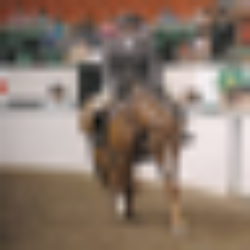

In [ ]:
random_img_idx = torch.randint(0, 1000, (1,)).item()

test_image = train_dataset[random_img_idx][0]  # 0 for image part in (image, label) tuple.
test_image = resize(test_image, (250, 250), antialias=None)  # better visualization
print(test_image.shape)
print('Number of channels in test_image: ', test_image.shape[0])
to_pil_image(test_image)

In [ ]:
tred, tgreen, tblue = test_image
empty_channel = torch.zeros_like(tred)

tred = [tred, empty_channel, empty_channel]  #R00
tgreen = [empty_channel, tgreen, empty_channel]  #0G0
tblue = [empty_channel, empty_channel, tblue]  #00B

channels = [torch.stack(img) for img in [tred, tgreen, tblue]]

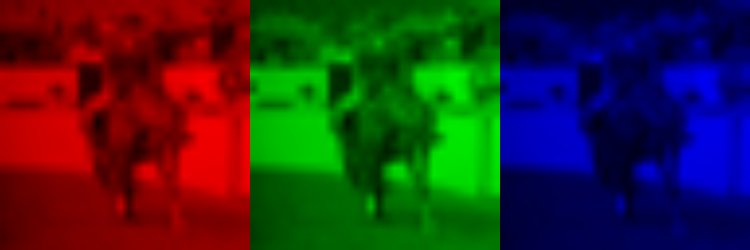

In [ ]:
to_pil_image(torch.cat(channels, dim=2))

In [ ]:
class Cifar10Classifier(nn.Module):

    def __init__(self):
        super(Cifar10Classifier, self).__init__()
        # create 4 conv layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2, stride=1) # 3 channels (RGB) , 32 filter
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=5, padding=2)
        # create 2 fully connected layers
        self.fc1 = nn.Linear(256 * 2 * 2, 512)
        self.fc2 = nn.Linear(512, 10)
        # create pool layer
        self.pool = nn.MaxPool2d(2,2)
        # create Relue layer
        self.relu = nn.ReLU()

        #create softmax layer
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x: torch.Tensor):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        x = x.flatten(start_dim=1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.softmax(x)

        return x

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # checks if machine supports cuda and if it does, we use that, otherwise cpu
model = Cifar10Classifier().to(device)

In [ ]:
num_epochs = 30
lr = 1e-4

train_losses = []
val_losses = []

optimizer = Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()  # multi-class

model.to(device)  # we need to send all input tensors as well as our model to this device. by default they are on cpu

print(f'Using device {device}')

Using device cuda


In [ ]:
%%time
for epoch_no in range(num_epochs):

  model.train()  # convert to train model. This turns out train-specific layers in the model (if you dont know about them, an example of them is dropout. more on this later)

  epoch_weighted_loss = 0

  for batch_X, batch_y in train_loader:

    batch_X = batch_X.to(device)
    batch_y = batch_y.to(device)

    batch_y_probs = model(batch_X)  # outputs [N, 10] where each [:, 10] is probabilities for class (0-9)

    loss = criterion(batch_y_probs, batch_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_weighted_loss += (len(batch_y)*loss.item())

  epoch_loss = epoch_weighted_loss/len(train_loader.dataset)
  train_losses.append(epoch_loss)


  # validation time

  model.eval()  # take model to evaluation mode. turn off train-only layers
  correctly_labelled = 0

  with torch.no_grad():

    val_epoch_weighted_loss = 0

    for val_batch_X, val_batch_y in val_loader:

      val_batch_X = val_batch_X.to(device)
      val_batch_y = val_batch_y.to(device)

      val_batch_y_probs = model(val_batch_X)

      loss = criterion(val_batch_y_probs, val_batch_y)
      val_epoch_weighted_loss += (len(val_batch_y)*loss.item())

      val_batch_y_pred = val_batch_y_probs.argmax(dim=1)  # convert probailities to labels by picking the label (index) with the highest prob

      correctly_labelled += (val_batch_y_pred == val_batch_y).sum().item()  # item converts tensor to float/int/list

  val_epoch_loss = val_epoch_weighted_loss/len(val_loader.dataset)
  val_losses.append(val_epoch_loss)

  print(f'Epoch: {epoch_no}, train_loss={epoch_loss}, val_loss={val_epoch_loss}. labelled {correctly_labelled}/{len(val_loader.dataset)} correctly ({correctly_labelled/len(val_loader.dataset)*100}% accuracy)')

print(f'Training complete on device {device}.')

Epoch: 0, train_loss=2.1568884273529054, val_loss=2.0874717418670654. labelled 3647/10000 correctly (36.47% accuracy)
Epoch: 1, train_loss=2.0824413494873046, val_loss=2.0390189323425294. labelled 4188/10000 correctly (41.88% accuracy)
Epoch: 2, train_loss=2.039843702392578, val_loss=2.026504274368286. labelled 4283/10000 correctly (42.83% accuracy)
Epoch: 3, train_loss=2.0105128433227537, val_loss=1.9905940780639648. labelled 4719/10000 correctly (47.19% accuracy)
Epoch: 4, train_loss=1.9789758947753906, val_loss=1.971998168182373. labelled 4864/10000 correctly (48.64% accuracy)
Epoch: 5, train_loss=1.9561705546569825, val_loss=1.9403972770690918. labelled 5193/10000 correctly (51.93% accuracy)
Epoch: 6, train_loss=1.9312487870025634, val_loss=1.9237249919891357. labelled 5383/10000 correctly (53.83% accuracy)
Epoch: 7, train_loss=1.9082992336273192, val_loss=1.906860050201416. labelled 5514/10000 correctly (55.14% accuracy)
Epoch: 8, train_loss=1.891210041847229, val_loss=1.892433959

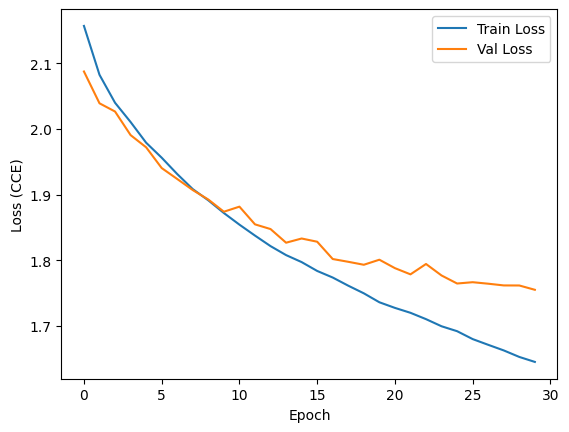

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses  , label='Val Loss')

plt.ylabel('Loss (CCE)')
plt.xlabel('Epoch')

plt.legend()
plt.show()